# Let's Play "A Movie Presentation"

## Overview

Our team, consisting of Whitlee, Yiyi and Jacob, was asked to present three business recommendations as our company establishes its very own movie studio.

## Business Understanding

As fun as it sounds to make movies, Tom Cruise (and others) have taught us that the business of making movies can be a... wait for it... Risky Business. Anyway, our company had no real knowledge of what makes a good movie or how to make a movie profitable, so our team was tasked with exploring data and running tests upon that data in order to provide that information and inform our business recommendations. 

In [73]:
import pandas as pd
import sqlite3
import re
import numpy as np
from math import sqrt
from scipy import stats

## Data Understanding

We were provided five (5) data files, from various sources, and our first task was to decide which of those data files were viable for our purposes and which were, for lack of a better word, useless. Of those five (5) available choices, "bom.movie_gross.csv.gz" contained financial information and only that, so we discarded it as we could find that information elsewhere. Additionally, "rt.movie_info.tsv.gz" and "rt.reviews.tsv.gz" were synopses and reviews respectively, and full of strings that would be quite difficult to quantify and proved unnecessary.

Therefore, we settled on using "im.db", a SQL database for IMDB. IMDB (or, the International Movie Database) is a very popular movie-ranking website. The IMDB dataset contained such fare as ratings, directors, and actors. This data spanned from 2010 to 2027 as it dealt with production budgets and movies still being made and scheduled.

Additionally, we chose to use "tmdb.movies.csv.gz". This data came from "The Movie Database", and spanned the years 2013 to 2018. We chose this dataset because it contained a rating system, as well as title information.

Finally, as our third data source, we chose "tn.movie_budgets.csv.gz". This data came from The Numbers, and features such information as budget (what a movie cost to make), domestic gross and worldwide gross. These figures are very important for mathematical calculations, and answering the question of how much a movie is worth in a quantifiable amount.

In [2]:
tmdb_df = pd.read_csv("Data/tmdb.movies.csv.gz")

In [3]:
tmdb_df.head(10)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
5,5,"[12, 14, 10751]",32657,en,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229
6,6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676
7,7,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340
8,8,"[16, 10751, 35]",20352,en,Despicable Me,23.673,2010-07-09,Despicable Me,7.2,10057
9,9,"[16, 28, 35, 10751, 878]",38055,en,Megamind,22.855,2010-11-04,Megamind,6.8,3635


In [4]:
tmdb_df.tail(10)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
26507,26507,[99],545555,ar,Dreamaway,0.6,2018-10-14,Dream Away,0.0,2
26508,26508,[16],514492,en,Jaws,0.6,2018-05-29,Jaws,0.0,1
26509,26509,[27],502255,en,Closing Time,0.6,2018-02-24,Closing Time,0.0,1
26510,26510,[99],495045,en,Fail State,0.6,2018-10-19,Fail State,0.0,1
26511,26511,[99],492837,en,Making Filmmakers,0.6,2018-04-07,Making Filmmakers,0.0,1
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.6,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.6,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.6,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.6,2018-06-22,Trailer Made,0.0,1
26516,26516,"[53, 27]",309885,en,The Church,0.6,2018-10-05,The Church,0.0,1


First we must load in the data and explore it. We began with the TMDB data, and a quick look at the first and last 10 entries show us some interesting things. Columns of note for later work include "genre_ids", "original_title" and "title", "release_date", and the two columns of voting information.

In [5]:
tmdb_df.describe()

,Unnamed: 0,id,popularity,vote_average,vote_count
count,26517.00000,26517.000000,26517.000000,26517.000000,26517.000000
mean,13258.00000,295050.153260,3.130912,5.991281,194.224837
std,7654.94288,153661.615648,4.355229,1.852946,960.961095
min,0.00000,27.000000,0.600000,0.000000,1.000000
25%,6629.00000,157851.000000,0.600000,5.000000,2.000000
50%,13258.00000,309581.000000,1.374000,6.000000,5.000000
75%,19887.00000,419542.000000,3.694000,7.000000,28.000000
max,26516.00000,608444.000000,80.773000,10.000000,22186.000000


In [6]:
tmdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


Above, we've explored the TMDB data a little further, and we see that there are no nulls in the data. Very helpful! Furthermore, we can see some of the counts of each column, as well as statistical data such as the mean, standard deviation, minimum and max in the columns that are integer based. We can also see that there are over 26,000 entries in this dataframe.

Now, we must do the same for the other two datasets, and the process is much the same, at least for the budgets data.

In [7]:
df = pd.read_csv("Data/tn.movie_budgets.csv.gz")

In [8]:
df.head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
6,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200"
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,"$300,000,000","$309,420,425","$963,420,425"
8,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209"
9,10,"Nov 6, 2015",Spectre,"$300,000,000","$200,074,175","$879,620,923"


In [9]:
df.tail(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
5772,73,"Jan 13, 2012",Newlyweds,"$9,000","$4,584","$4,584"
5773,74,"Feb 26, 1993",El Mariachi,"$7,000","$2,040,920","$2,041,928"
5774,75,"Oct 8, 2004",Primer,"$7,000","$424,760","$841,926"
5775,76,"May 26, 2006",Cavite,"$7,000","$70,071","$71,644"
5776,77,"Dec 31, 2004",The Mongol King,"$7,000",$900,$900
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0
5781,82,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041"


From a quick exploration of The Numbers data, we can see that the columns include "release_date", "movie" (or title), "production_budget", and the gross for both domestic and worldwide. Since it is indisputable that money makes the world go 'round, the budgetary and gross information here will be absolutely critical.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [11]:
df.describe()

,id
count,5782.000000
mean,50.372363
std,28.821076
min,1.000000
25%,25.000000
50%,50.000000
75%,75.000000
max,100.000000


Now, here is where things get interesting for The Numbers' data. We can see that there are over 5700 entries, and no nulls. However, the main monetary columns are listed as objects rather than integers or floats, which will make later necessary math operations a pain in the buttsholes. We will revisit a .describe() on this dataframe after we've done some cleaning and can then see the mean, standard deviation, minimum and maximum for the monetary columns.

Finally, in terms of our basic data understanding, we must load in the IMDB SQL Database and attempt to discover roughly the same information, though the schema is very different and so therefore is the information contained within.

In [12]:
conn = sqlite3.connect('Data/im.db')
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)
print(tables)

            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


As we can see, SQL works a little (a lot) differently from Pandas, and so what we are able to ascertain (thus far) are the tables contained within. These are such things as "movie_basics", "directors", "persons", and so on. These will be useful in terms of determining whether a certain writer, actor, or director has an influence in the popularity or revenue of a movie. We did, however, need to do a little more exploration to ascertain what each table contained and its relevance.

In [13]:
q_1 = """
SELECT * FROM movie_akas
"""
movie_akas = pd.read_sql_query(q_1, conn)
movie_akas.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [14]:
q_2 = """
SELECT * FROM movie_basics
"""
movie_basics = pd.read_sql_query(q_2, conn)
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


From these first two queries to the database, we have pulled the results from "movie_akas" and "movie_basics", respectively, to get an idea of what each table contains and the relevance of that information. "movies_akas" contains such things as "title" and "region", but sadly is not particularly of use outside of that, featuring no ratings, budgetary information, or revenue information. "movie_basics" is contains notable things such as "genres" and "runtime_minutes".

In [15]:
q_3 = """
SELECT * FROM directors
"""
directors = pd.read_sql_query(q_3, conn)
directors.head()

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


In [16]:
q_4 = """
SELECT * FROM known_for
"""
known_for = pd.read_sql_query(q_4, conn)
known_for.head()

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241
2,nm0061671,tt0844471
3,nm0061671,tt0118553
4,nm0061865,tt0896534


These two queries were interesting in terms of discovering what each table contained, but overall useless.

In [17]:
q_5 = """
SELECT * FROM movie_ratings
"""
movie_ratings = pd.read_sql_query(q_5, conn)
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [18]:
q_6 = """
SELECT * FROM persons
"""
persons = pd.read_sql_query(q_6, conn)
persons.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [19]:
q_7 = """
SELECT * FROM principals
"""
principals = pd.read_sql_query(q_7, conn)
principals.head()

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"


These next few queries proved to be much more useful, as the table "movie_ratings" is incredibly relevant, containing information on the average rating of each movie and the number of votes it received to arrive at that number. The second table, "persons", contains the names and professions of actors, writers, directors, and so on. Dovetailing with the second table, the third, "principals", further informs us about the actors, producers, directors, and those involved in the making of the movie, and may be very relevant to our third recommendation.

## Data Preparation

Now, we must move on to cleaning up our data, removing nulls and ensuring that things are standardized. We begin with The Movie Database dataframe, henceforth referred to as "tmdb_df" both in code and markdown. It is briefly shown below.

In [20]:
tmdb_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


The first thing that steamed our broccoli as regarded this data was that the "genre_ids" column was in number form rather than any sort of understandable terms like "action" or "drama". Blessedly, Yiyi came right to the rescue and did a little extraneous research, discovering that these numbers are an industry standard for genres. Therefore, she was able to write a code to change the values from their respective integer value to the proper genre, as we needed.

In [21]:
genre_mapping = {
    28: "Action", 12: "Adventure", 16: "Animation", 35: "Comedy", 80: "Crime", 
    99: "Documentary", 18: "Drama", 10751: "Family", 14: "Fantasy", 36: "History", 
    27: "Horror", 10402: "Music", 9648: "Mystery", 10749: "Romance", 878: "Science Fiction", 
    10770: "TV Movie", 53: "Thriller", 10752: "War", 37: "Western"
}

In [22]:
def convert_genre_ids_to_names(ids):
    genre_ids = re.findall(r'\d+', ids)
    return ', '.join([genre_mapping.get(int(id), "Unknown") for id in genre_ids])

tmdb_df['genre_ids'] = tmdb_df['genre_ids'].apply(convert_genre_ids_to_names)

In [23]:
tmdb_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"Adventure, Fantasy, Family",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"Fantasy, Adventure, Animation, Family",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"Adventure, Action, Science Fiction",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"Animation, Comedy, Family",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"Action, Science Fiction, Adventure",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


Lovely! Now, we have the genres in an understandable format that we can compare easily to the other genres seen in our available data. Our next "issue" was whether the available movie data was movies that were in English. However, another brief look showed us that roughly 23,000 of the 26,500 entries in the dataframe were in English, so we felt comfortable removing those that were not.

In [24]:
tmdb_df = tmdb_df.loc[tmdb_df['original_language'] == "en"]

In [25]:
tmdb_df['original_language'].value_counts()

en    23291
Name: original_language, dtype: int64

As we can see, we still have upwards of 23,000 results to work with. Now, we had some concerns that there might be duplicates within the "original_title" and "title" columns, so we set about exploring and fixing that.

In [26]:
tmdb_df['original_title'].value_counts()

Eden                             7
Home                             6
Aftermath                        5
Legend                           5
Lucky                            5
                                ..
The Infinite Happiness           1
Spinning Man                     1
Magic Mike XXL                   1
Fear Clinic                      1
Memphis: The Broadway Musical    1
Name: original_title, Length: 21781, dtype: int64

In [27]:
tmdb_df = tmdb_df.drop_duplicates(subset=['original_title'])

In [28]:
tmdb_df['original_title'].value_counts()

Día de los muertos               1
Theatre of the Deranged          1
Where is Robert Fisher?          1
Hansel and Gretel Get Baked      1
Coldwater                        1
                                ..
Monster High: Fright On!         1
Ant Head                         1
Killing Reagan                   1
Pauly Shore Stands Alone         1
Memphis: The Broadway Musical    1
Name: original_title, Length: 21781, dtype: int64

In [29]:
tmdb_df['title'].value_counts()

Serenade                                                2
Brothers                                                2
Friend Request                                          2
Alone                                                   2
Legion                                                  2
                                                       ..
A Radio Drama Goodbye                                   1
Thieves                                                 1
The Lies We Tell But the Secrets We Keep (Part 2)       1
Ken Block's GYMKHANA TEN: Ultimate Tire Slaying Tour    1
Memphis: The Broadway Musical                           1
Name: title, Length: 21767, dtype: int64

In [30]:
tmdb_df = tmdb_df.drop_duplicates(subset=['title'])

In [31]:
tmdb_df['title'].value_counts()

Día de los muertos                           1
Tony Story                                   1
Fighting Fish                                1
Where is Robert Fisher?                      1
Hansel and Gretel Get Baked                  1
                                            ..
Lennon Naked                                 1
Money as Debt III: Evolution Beyond Money    1
Newness                                      1
Pig Pen                                      1
Memphis: The Broadway Musical                1
Name: title, Length: 21767, dtype: int64

In [32]:
tmdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21767 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         21767 non-null  int64  
 1   genre_ids          21767 non-null  object 
 2   id                 21767 non-null  int64  
 3   original_language  21767 non-null  object 
 4   original_title     21767 non-null  object 
 5   popularity         21767 non-null  float64
 6   release_date       21767 non-null  object 
 7   title              21767 non-null  object 
 8   vote_average       21767 non-null  float64
 9   vote_count         21767 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 1.8+ MB


As we can see, there were some duplicates within both columns, and so we dropped any duplicate rows and further trimmed our data down to nearly 22,000 entries. Still a very respectable dataset! 

Now, contained within that data was a voting average based on a vote count that approximated how popular the movie was. Some very important pieces of information, especially considering that popularity is a huge part of what makes a successful movie. People don't spend money on things they don't like. Now, it could be said that when few people vote for something, they're disinterested, so we opted to remove the bottom "chunk" of votes. Not enough people saw that movie for it to be relevant, in other words.

In [33]:
tmdb_df.describe()

,Unnamed: 0,id,popularity,vote_average,vote_count
count,21767.000000,21767.000000,21767.000000,21767.000000,21767.000000
mean,13063.441953,297996.045620,2.963221,5.946226,187.565397
std,7609.083387,153589.915884,4.323317,1.912034,949.350173
min,0.000000,27.000000,0.600000,0.000000,1.000000
25%,6535.500000,160783.000000,0.600000,5.000000,1.000000
50%,12972.000000,311093.000000,1.182000,6.000000,4.000000
75%,19602.500000,422517.000000,3.110000,7.000000,22.000000
max,26516.000000,608444.000000,80.773000,10.000000,22186.000000


There are a lot of low outliers in the vote_count and vote_average columns, meaning that there are many entries here that not a lot of people saw. Those aren't particularly relevant to our data, so by using the mean vote count displayed here, 188, we set a cutoff for a vote amount, which is a backend way of judging by popularity.

In [34]:
tmdb_df = tmdb_df[tmdb_df['vote_count'] >= 188]

In [35]:
tmdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2143 entries, 0 to 24472
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2143 non-null   int64  
 1   genre_ids          2143 non-null   object 
 2   id                 2143 non-null   int64  
 3   original_language  2143 non-null   object 
 4   original_title     2143 non-null   object 
 5   popularity         2143 non-null   float64
 6   release_date       2143 non-null   object 
 7   title              2143 non-null   object 
 8   vote_average       2143 non-null   float64
 9   vote_count         2143 non-null   int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 184.2+ KB


This has still left us with a very respectable 2100 entries. Now, at this point, we have ensured our entries are all in English, and that the original titles and titles match. Due to this, we decided to then drop "original_title" and "original_language", as well as "id". We didn't feel "id" was informative nor necessary as a connective point. 'Unnamed' also didn't seem important, so we dropped that as well.

In [36]:
tmdb_df = tmdb_df.drop(['id', 'original_language', 'original_title', 'Unnamed: 0'], axis=1)

In [37]:
tmdb_df

,genre_ids,popularity,release_date,title,vote_average,vote_count
0,"Adventure, Fantasy, Family",33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"Fantasy, Adventure, Animation, Family",28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"Adventure, Action, Science Fiction",28.515,2010-05-07,Iron Man 2,6.8,12368
3,"Animation, Comedy, Family",28.005,1995-11-22,Toy Story,7.9,10174
4,"Action, Science Fiction, Adventure",27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...
24271,Comedy,8.669,2018-04-27,The Week Of,5.1,344
24275,"Drama, Fantasy, Horror, Thriller",8.631,2018-01-05,Before I Wake,6.4,941
24287,"Romance, Drama, History",8.402,2018-08-10,The Guernsey Literary & Potato Peel Pie Society,7.7,594
24338,Comedy,7.897,2018-01-19,Step Sisters,6.4,285


Finally, we sort the values based on "vote_average" because we only care about the "most popular" movies.

In [38]:
tmdb_df = tmdb_df.sort_values(by='vote_average', ascending=False)

In [39]:
tmdb_df

,genre_ids,popularity,release_date,title,vote_average,vote_count
23861,"Drama, History, War",25.334,1993-12-15,Schindler's List,8.5,8065
23812,"Action, Adventure, Animation, Science Fiction,...",60.534,2018-12-14,Spider-Man: Into the Spider-Verse,8.4,4048
5201,"Drama, Crime",17.717,1984-06-01,Once Upon a Time in America,8.4,2243
11142,Drama,11.095,2014-08-29,Mommy,8.3,1399
23827,"Drama, Comedy",36.284,2018-11-16,Green Book,8.3,3499
...,...,...,...,...,...,...
17895,Horror,6.403,2016-07-01,Satanic,4.0,241
23932,"Mystery, Thriller, Horror",16.999,2018-08-10,Slender Man,4.0,712
8170,"Science Fiction, TV Movie, Action, Adventure, ...",7.465,2013-07-11,Sharknado,3.8,873
24230,"Thriller, Horror",9.178,2018-01-19,The Open House,3.7,791


In [40]:
tmdb_df.to_csv('Data/tmdb_df_redone.csv', index=False)

Et voila! We have our cleaned dataset, ready to be joined with other dataframes and experimented on, for lack of a better word. Now, we move on to the second dataset and more or less repeat the process. For this portion, we will be working with The Numbers data, henceforth referred to as "budgets_df" both in code and markdown. The data is displayed briefly below for a refresher.

In [41]:
df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


The first "issue" noted was that the "$" from the monetary columns needed to be removed, both for cleanliness and potentially for later math calculations. There was no need to "muddy the waters" with additional symbols. Additionally, the monetary columns are listed as "objects" rather than integers or floats, and that will need to be fixed for math calculations as well.

In [43]:
#removing $ from monetary columns
df['production_budget'] = df['production_budget'].replace('[\$,]', '', regex=True).astype(int)

# Check the result
print(df['production_budget'])

0       425000000
1       410600000
2       350000000
3       330600000
4       317000000
          ...    
5777         7000
5778         6000
5779         5000
5780         1400
5781         1100
Name: production_budget, Length: 5782, dtype: int32


In [44]:
#removing $ from monetary columns
df['domestic_gross'] = df['domestic_gross'].replace('[\$,]', '', regex=True).astype(int)

# Check the result
print(df['domestic_gross'])

0       760507625
1       241063875
2        42762350
3       459005868
4       620181382
          ...    
5777            0
5778        48482
5779         1338
5780            0
5781       181041
Name: domestic_gross, Length: 5782, dtype: int32


In [45]:
#removing $ from monetary columns
df['worldwide_gross'] = df['worldwide_gross'].replace('[\$,]', '', regex=True).astype(np.int64)


# Check the result
print(df['worldwide_gross'])

0       2776345279
1       1045663875
2        149762350
3       1403013963
4       1316721747
           ...    
5777             0
5778        240495
5779          1338
5780             0
5781        181041
Name: worldwide_gross, Length: 5782, dtype: int64


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int32 
 4   domestic_gross     5782 non-null   int32 
 5   worldwide_gross    5782 non-null   int64 
dtypes: int32(2), int64(2), object(2)
memory usage: 226.0+ KB


Now, the unsightly dollar signs have been removed, and the monetary columns are listed as integers, meaning that math can be performed upon them as necessary. It also means we can get the standard deviation, minimum, maximum, and other information for those columns now.

In [47]:
df.describe()

,id,production_budget,domestic_gross,worldwide_gross
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09


Obviously, in the context of budget discussions, we care about which movies made the most money, and so we've sorted the data by "worldwide_gross".

In [48]:
df = df.sort_values(by='worldwide_gross', ascending=False)

In [49]:
df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
42,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200
33,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864
...,...,...,...,...,...,...
5474,75,"Dec 31, 2005",Insomnia Manica,500000,0,0
5473,74,"Jul 17, 2012",Girls Gone Dead,500000,0,0
5472,73,"Apr 3, 2012",Enter Nowhere,500000,0,0
5471,72,"Dec 31, 2010",Drones,500000,0,0


We wanted to ensure that the dataframe had no null values, and that process can be seen here.

In [50]:
#making sure there are no null values
null_values = df.isnull().sum()

# Display the count of null values for each column
print(null_values)

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64


Now, we must clean and connect the SQL data with everything else, and decide what we need and do not for our recommendations. We chose to pursue a path wherein our recommendation detailed whom the best actor/actress was and then allowed us to formulate a recommendation and statistical test based on that. See that process below.

In [51]:
best_actors = """

SELECT pe.primary_name AS "Primary Name", pr.category AS "Position",mr.averagerating AS "Average Rating", mr.numvotes AS "Num of Votes"
FROM principals AS pr
  JOIN persons AS pe
    ON pr.person_id = pe.person_id
      JOIN movie_ratings AS mr
        ON mr.movie_id = pr.movie_id
  WHERE mr.numvotes > 5000 AND "Position" = "actor"
  ORDER BY "Average Rating" DESC
  
  
"""
best_actors = pd.read_sql_query(best_actors, conn)
best_actors.head(20)

,Primary Name,Position,Average Rating,Num of Votes
0,Leonardo DiCaprio,actor,9.7,5600
1,Brad Pitt,actor,9.7,5600
2,Timothy Olyphant,actor,9.7,5600
3,Uddika Premarathna,actor,9.5,6509
4,Roshan Ravindra,actor,9.5,6509
5,Mammootty,actor,9.4,9629
6,Donavon Warren,actor,9.3,17308
7,Patrick Hume,actor,9.3,17308
8,Kevin McCorkle,actor,9.3,17308
9,Ozan Agaç,actor,9.3,100568


That done, we must now begin the process of sorting the movies by movie length and trimming out "Documentaries", as there is not an overwhelming amount of money in documentaries and thus we did not feel our company would be interested in such data.

In [52]:
combo_1 = """

SELECT ma.movie_id AS "Movie ID", mb.primary_title AS "Primary Title", mb.runtime_minutes as "Movie Length",mb.genres AS "Genres",mr.averagerating AS "Average Rating", mr.numvotes AS "Num of Votes",pe.primary_name AS "Primary Name", pr.category AS "Position" 
FROM movie_akas AS ma
  JOIN movie_basics AS mb
      ON ma.movie_id = mb.movie_id
       JOIN movie_ratings AS mr
          ON mb.movie_id = mr.movie_id
         JOIN principals AS pr
           ON pr.movie_id = mr.movie_id
            JOIN persons AS pe
             ON pe.person_id = pr.person_id
  GROUP BY ma.movie_id
  ORDER BY "Movie Length" DESC
  
"""
combo_ONE = pd.read_sql_query(combo_1, conn)
combo_ONE.head()

,Movie ID,Primary Title,Movie Length,Genres,Average Rating,Num of Votes,Primary Name,Position
0,tt8273150,Logistics,51420.0,Documentary,5.0,17,Erika Magnusson,director
1,tt2659636,Modern Times Forever,14400.0,Documentary,6.2,69,Nicolas Gaitan,actor
2,tt2008009,The Clock,1440.0,Drama,8.9,219,Leonardo DiCaprio,archive_footage
3,tt9047474,La flor,808.0,"Drama,Fantasy,Musical",8.5,100,Gabriel Chwojnik,composer
4,tt7528992,Europa: The Last Battle,746.0,Documentary,8.2,162,Winston Churchill,self


In [53]:
filtered_df = combo_ONE[(combo_ONE['Genres'] != 'Documentary') & (combo_ONE['Movie Length'] >= 100.0) & (combo_ONE['Movie Length'] <= 180.0)]
ordered_df = filtered_df.sort_values(by = 'Average Rating', ascending=False)
num_of_votes_filter = ordered_df.sort_values(by = 'Num of Votes', ascending=False)
IMDB_df = ordered_df[(ordered_df['Num of Votes'] >= 7500) & (ordered_df['Average Rating'] >= 5.0)]
IMDB_df.sort_values(by="Movie Length", ascending=False)

,Movie ID,Primary Title,Movie Length,Genres,Average Rating,Num of Votes,Primary Name,Position
254,tt2278871,Blue Is the Warmest Color,180.0,"Drama,Romance",7.8,124409,Abdellatif Kechiche,director
266,tt0993846,The Wolf of Wall Street,180.0,"Biography,Crime,Drama",8.2,1035358,Leonardo DiCaprio,actor
250,tt2461132,Happy New Year,180.0,"Action,Comedy,Music",5.1,31583,Farah Khan,director
300,tt2176013,Jab Tak Hai Jaan,176.0,"Drama,Romance",6.8,48364,A.R. Rahman,composer
313,tt5312232,Sairat,174.0,"Drama,Romance",8.4,9656,Nitin Keni,producer
...,...,...,...,...,...,...,...,...
18078,tt8155288,Happy Death Day 2U,100.0,"Drama,Horror,Mystery",6.3,27462,Toby Oliver,cinematographer
19716,tt1619029,Jackie,100.0,"Biography,Drama,History",6.7,66008,Natalie Portman,actress
19171,tt2400463,The Invitation,100.0,"Drama,Horror,Mystery",6.7,70213,Phil Hay,writer
18953,tt3170902,Theeb,100.0,"Adventure,Drama,Thriller",7.2,8921,Wolfgang Thaler,cinematographer


In [54]:
IMDB_df.to_csv('df_yi_1.csv', index=False)

In [55]:
IMDB_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1920 entries, 1550 to 8998
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Movie ID        1920 non-null   object 
 1   Primary Title   1920 non-null   object 
 2   Movie Length    1920 non-null   float64
 3   Genres          1920 non-null   object 
 4   Average Rating  1920 non-null   float64
 5   Num of Votes    1920 non-null   int64  
 6   Primary Name    1920 non-null   object 
 7   Position        1920 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 135.0+ KB


Above, we have transformed our SQL database files into a workable CSV that we can then read into a Pandas dataframe and use it with the other information we have available to further inform our analysis. Now, we must merge the "budgets_df" and "IMDB_df" in order to allow for budgetary information in conjunction with popular actors.

In [56]:
Merged_df_1 = pd.merge(IMDB_df, df, left_on='Primary Title', right_on='movie', how='inner')

In [57]:
Merged_df_1

,Movie ID,Primary Title,Movie Length,Genres,Average Rating,Num of Votes,Primary Name,Position,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt1375666,Inception,148.0,"Action,Adventure,Sci-Fi",8.8,1841066,Leonardo DiCaprio,actor,38,"Jul 16, 2010",Inception,160000000,292576195,835524642
1,tt0816692,Interstellar,169.0,"Adventure,Drama,Sci-Fi",8.6,1299334,Matthew McConaughey,actor,32,"Nov 5, 2014",Interstellar,165000000,188017894,666379375
2,tt2582802,Whiplash,106.0,"Drama,Music",8.5,616916,Paul Reiser,actor,43,"Oct 10, 2014",Whiplash,3300000,13092006,38969037
3,tt4154756,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926,Robert Downey Jr.,actor,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200
4,tt0770802,Samsara,102.0,"Documentary,Music",8.5,29725,Ron Fricke,director,18,"Aug 24, 2012",Samsara,4000000,2672413,5966671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,tt3835080,31,102.0,"Horror,Thriller",5.1,15055,Malcolm McDowell,actor,85,"Oct 21, 2016",31,1500000,779820,922727
973,tt1532958,Battle of the Year,110.0,"Drama,Music",5.1,8769,Beau Flynn,producer,51,"Sep 20, 2013",Battle of the Year,20000000,8888355,16723377
974,tt2690138,The D Train,101.0,"Comedy,Drama",5.0,10066,Jeffrey Tambor,actor,34,"May 8, 2015",The D Train,3000000,669688,772366
975,tt0808510,Tooth Fairy,101.0,"Comedy,Family,Fantasy",5.0,37939,Ashley Judd,actress,23,"Jan 22, 2010",Tooth Fairy,48000000,60022256,112610386


In [58]:
Merged_df_1.to_csv('merged_df_JY.csv', index=False)

In [59]:
def standardize_genre_order(genre_string):
    # Split the string into a list, strip whitespace, sort it, and join back into a string
    genres = [genre.strip() for genre in genre_string.split(',')]
    genres.sort()
    return ', '.join(genres)

# Apply the function to the 'Genre Ids' column
Merged_df_1['Genres'] = Merged_df_1['Genres'].apply(standardize_genre_order)
Merged_df_1.head()

,Movie ID,Primary Title,Movie Length,Genres,Average Rating,Num of Votes,Primary Name,Position,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt1375666,Inception,148.0,"Action, Adventure, Sci-Fi",8.8,1841066,Leonardo DiCaprio,actor,38,"Jul 16, 2010",Inception,160000000,292576195,835524642
1,tt0816692,Interstellar,169.0,"Adventure, Drama, Sci-Fi",8.6,1299334,Matthew McConaughey,actor,32,"Nov 5, 2014",Interstellar,165000000,188017894,666379375
2,tt2582802,Whiplash,106.0,"Drama, Music",8.5,616916,Paul Reiser,actor,43,"Oct 10, 2014",Whiplash,3300000,13092006,38969037
3,tt4154756,Avengers: Infinity War,149.0,"Action, Adventure, Sci-Fi",8.5,670926,Robert Downey Jr.,actor,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200
4,tt0770802,Samsara,102.0,"Documentary, Music",8.5,29725,Ron Fricke,director,18,"Aug 24, 2012",Samsara,4000000,2672413,5966671


Having thus merged "budgets_df" and "IMDB_df", we now have access to the budgetary information connected with principal performer information. One last bit of "data cleaning" is to merge the "budgets_df" and "tmdb_df" dataframes so that we have access to the popularity and budgetary information together as well.

In [60]:
Merged_df_1.to_csv('Merged_df_JY2.csv', index=False)

In [61]:
merged_j_w = pd.read_csv("Notebooks/result_df.csv")

In [62]:
merged_j_w

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,Unnamed: 0,genre_ids,popularity,title,vote_average,vote_count,weighted_rating
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,6,"Action, Adventure, Fantasy, Science Fiction",26.526,Avatar,7.4,18676,7.330873
1,67,2009-12-18,Did You Hear About the Morgans?,58000000,29580087,80480566,6,"Action, Adventure, Fantasy, Science Fiction",26.526,Avatar,7.4,18676,7.330873
2,100,2009-12-18,Nine,80000000,19676965,53508858,6,"Action, Adventure, Fantasy, Science Fiction",26.526,Avatar,7.4,18676,7.330873
3,28,2009-12-18,The Young Victoria,35000000,11001272,31878891,6,"Action, Adventure, Fantasy, Science Fiction",26.526,Avatar,7.4,18676,7.330873
4,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,14172,"Action, Adventure, Science Fiction, Fantasy",32.281,Star Wars: The Force Awakens,7.4,12641,7.304201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,34,2014-10-31,Nightcrawler,8500000,32381218,50334418,11039,"Crime, Drama, Thriller",25.597,Nightcrawler,7.7,5860,7.429301
1166,49,2014-10-31,Before I Go to Sleep,22000000,3242457,19563579,11039,"Crime, Drama, Thriller",25.597,Nightcrawler,7.7,5860,7.429301
1167,59,2014-10-31,All You Need Is Love,300000,0,3565259,11039,"Crime, Drama, Thriller",25.597,Nightcrawler,7.7,5860,7.429301
1168,77,1996-01-19,From Dusk Till Dawn,20000000,25728961,25732986,2500,"Horror, Action, Thriller, Crime",16.064,From Dusk Till Dawn,7.0,3015,6.950391


In [63]:
def standardize_genre_order(genre_string):
    # Split the string into a list, strip whitespace, sort it, and join back into a string
    genres = [genre.strip() for genre in genre_string.split(',')]
    genres.sort()
    return ', '.join(genres)

merged_j_w['genre_ids'] = merged_j_w['genre_ids'].apply(standardize_genre_order)

As you'll see, we have also standardized genre on both datasets so that we know our calculations and further data visuals are clean.

## Analysis and Results

In [64]:
tmdb_df

,genre_ids,popularity,release_date,title,vote_average,vote_count
23861,"Drama, History, War",25.334,1993-12-15,Schindler's List,8.5,8065
23812,"Action, Adventure, Animation, Science Fiction,...",60.534,2018-12-14,Spider-Man: Into the Spider-Verse,8.4,4048
5201,"Drama, Crime",17.717,1984-06-01,Once Upon a Time in America,8.4,2243
11142,Drama,11.095,2014-08-29,Mommy,8.3,1399
23827,"Drama, Comedy",36.284,2018-11-16,Green Book,8.3,3499
...,...,...,...,...,...,...
17895,Horror,6.403,2016-07-01,Satanic,4.0,241
23932,"Mystery, Thriller, Horror",16.999,2018-08-10,Slender Man,4.0,712
8170,"Science Fiction, TV Movie, Action, Adventure, ...",7.465,2013-07-11,Sharknado,3.8,873
24230,"Thriller, Horror",9.178,2018-01-19,The Open House,3.7,791


As we can see from our "tmdb_df" data, we have the movies arranged by "vote_average", meaning "most popular". With this, we were able to extrapolate which genres were the most popular. That visual can be seen below.

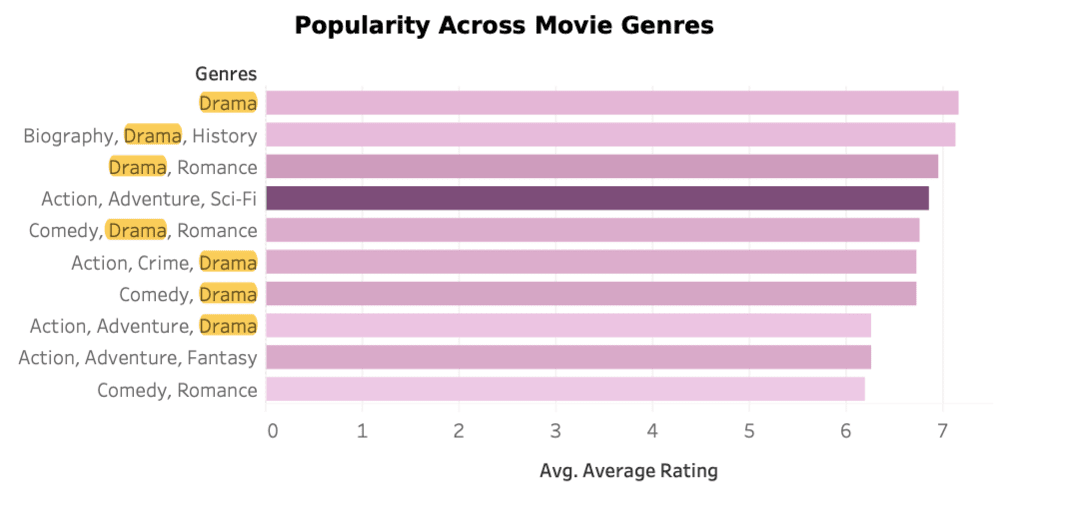

In [65]:
Merged_df_1.sort_values('production_budget', ascending=False)

,Movie ID,Primary Title,Movie Length,Genres,Average Rating,Num of Votes,Primary Name,Position,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
507,tt1298650,Pirates of the Caribbean: On Stranger Tides,136.0,"Action, Adventure, Fantasy",6.6,447624,Johnny Depp,actor,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
790,tt6565702,Dark Phoenix,113.0,"Action, Adventure, Sci-Fi",6.0,24451,John Byrne,writer,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
236,tt2395427,Avengers: Age of Ultron,141.0,"Action, Adventure, Sci-Fi",7.3,665594,Robert Downey Jr.,actor,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
3,tt4154756,Avengers: Infinity War,149.0,"Action, Adventure, Sci-Fi",8.5,670926,Robert Downey Jr.,actor,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200
442,tt2379713,Spectre,148.0,"Action, Adventure, Thriller",6.8,352504,Ralph Fiennes,actor,10,"Nov 6, 2015",Spectre,300000000,200074175,879620923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,tt4126476,After,105.0,"Drama, Romance",5.6,7699,Jennifer Beals,actress,2,"Dec 31, 2012",After,650000,0,0
538,tt1502407,Halloween,106.0,"Horror, Thriller",6.6,88395,John Carpenter,writer,37,"Oct 17, 1978",Halloween,325000,47000000,70000000
303,tt2053463,Side Effects,106.0,"Crime, Drama, Mystery",7.1,168466,Jude Law,actor,29,"Sep 9, 2005",Side Effects,200000,44701,44701
619,tt4196450,The Birth of a Nation,120.0,"Biography, Drama, History",6.4,18442,Penelope Ann Miller,actress,78,"Feb 8, 1915",The Birth of a Nation,110000,10000000,11000000


In [66]:
Merged_df_1.sort_values('worldwide_gross', ascending=False)

,Movie ID,Primary Title,Movie Length,Genres,Average Rating,Num of Votes,Primary Name,Position,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
3,tt4154756,Avengers: Infinity War,149.0,"Action, Adventure, Sci-Fi",8.5,670926,Robert Downey Jr.,actor,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200
358,tt0369610,Jurassic World,124.0,"Action, Adventure, Sci-Fi",7.0,539338,Michael Crichton,writer,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864
250,tt2820852,Furious 7,137.0,"Action, Crime, Thriller",7.2,335074,Brian Tyler,composer,67,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794
22,tt0848228,The Avengers,143.0,"Action, Adventure, Sci-Fi",8.1,1183655,Robert Downey Jr.,actor,27,"May 4, 2012",The Avengers,225000000,623279547,1517935897
236,tt2395427,Avengers: Age of Ultron,141.0,"Action, Adventure, Sci-Fi",7.3,665594,Robert Downey Jr.,actor,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,tt1924429,Trance,101.0,"Crime, Drama, Mystery",6.9,104951,Danny Boyle,director,31,"Dec 31, 2012",Trance,950000,0,0
540,tt2737304,Bird Box,124.0,"Drama, Horror, Sci-Fi",6.6,218063,Sandra Bullock,actress,17,"Dec 13, 2018",Bird Box,19800000,0,0
105,tt1942884,Indie Game: The Movie,103.0,"Documentary, Drama",7.7,19538,Lisanne Pajot,director,92,"May 18, 2012",Indie Game: The Movie,100000,0,0
932,tt4154916,Replicas,107.0,"Drama, Sci-Fi, Thriller",5.4,17336,Keanu Reeves,actor,62,"Nov 9, 2012",Replicas,4000000,0,0


Now that we've sorted our merged tables by production budget, we can see which genres of movie cost the most to make, and better advise our company from there. No risk, no reward, but many of these genres cost an absurd amount of money to make, and we may not have the capital for such an investment. The visual to support this point can be seen below.

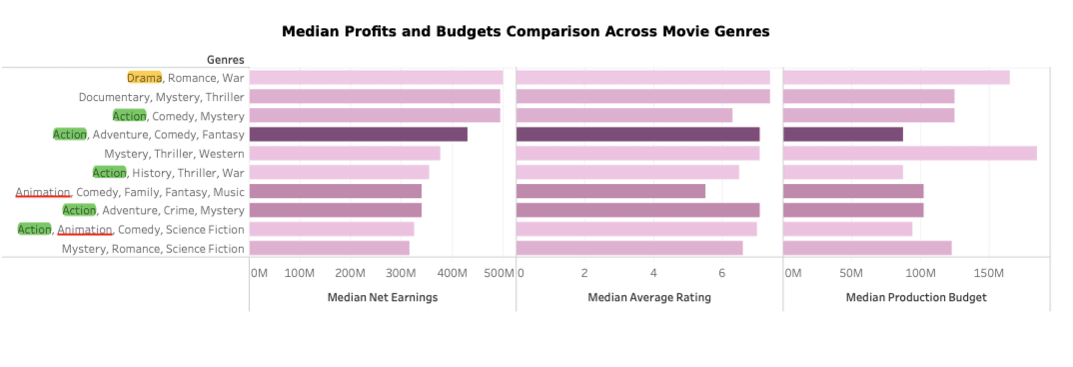

In [67]:
Merged_df_1

,Movie ID,Primary Title,Movie Length,Genres,Average Rating,Num of Votes,Primary Name,Position,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt1375666,Inception,148.0,"Action, Adventure, Sci-Fi",8.8,1841066,Leonardo DiCaprio,actor,38,"Jul 16, 2010",Inception,160000000,292576195,835524642
1,tt0816692,Interstellar,169.0,"Adventure, Drama, Sci-Fi",8.6,1299334,Matthew McConaughey,actor,32,"Nov 5, 2014",Interstellar,165000000,188017894,666379375
2,tt2582802,Whiplash,106.0,"Drama, Music",8.5,616916,Paul Reiser,actor,43,"Oct 10, 2014",Whiplash,3300000,13092006,38969037
3,tt4154756,Avengers: Infinity War,149.0,"Action, Adventure, Sci-Fi",8.5,670926,Robert Downey Jr.,actor,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200
4,tt0770802,Samsara,102.0,"Documentary, Music",8.5,29725,Ron Fricke,director,18,"Aug 24, 2012",Samsara,4000000,2672413,5966671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,tt3835080,31,102.0,"Horror, Thriller",5.1,15055,Malcolm McDowell,actor,85,"Oct 21, 2016",31,1500000,779820,922727
973,tt1532958,Battle of the Year,110.0,"Drama, Music",5.1,8769,Beau Flynn,producer,51,"Sep 20, 2013",Battle of the Year,20000000,8888355,16723377
974,tt2690138,The D Train,101.0,"Comedy, Drama",5.0,10066,Jeffrey Tambor,actor,34,"May 8, 2015",The D Train,3000000,669688,772366
975,tt0808510,Tooth Fairy,101.0,"Comedy, Family, Fantasy",5.0,37939,Ashley Judd,actress,23,"Jan 22, 2010",Tooth Fairy,48000000,60022256,112610386


Now, from this list sorted by popularity, it might seem like Leonardo DiCaprio would be a clear choice. However, due to the massive hiring cost entailed, we chose to recommend Robert Downey Jr instead.

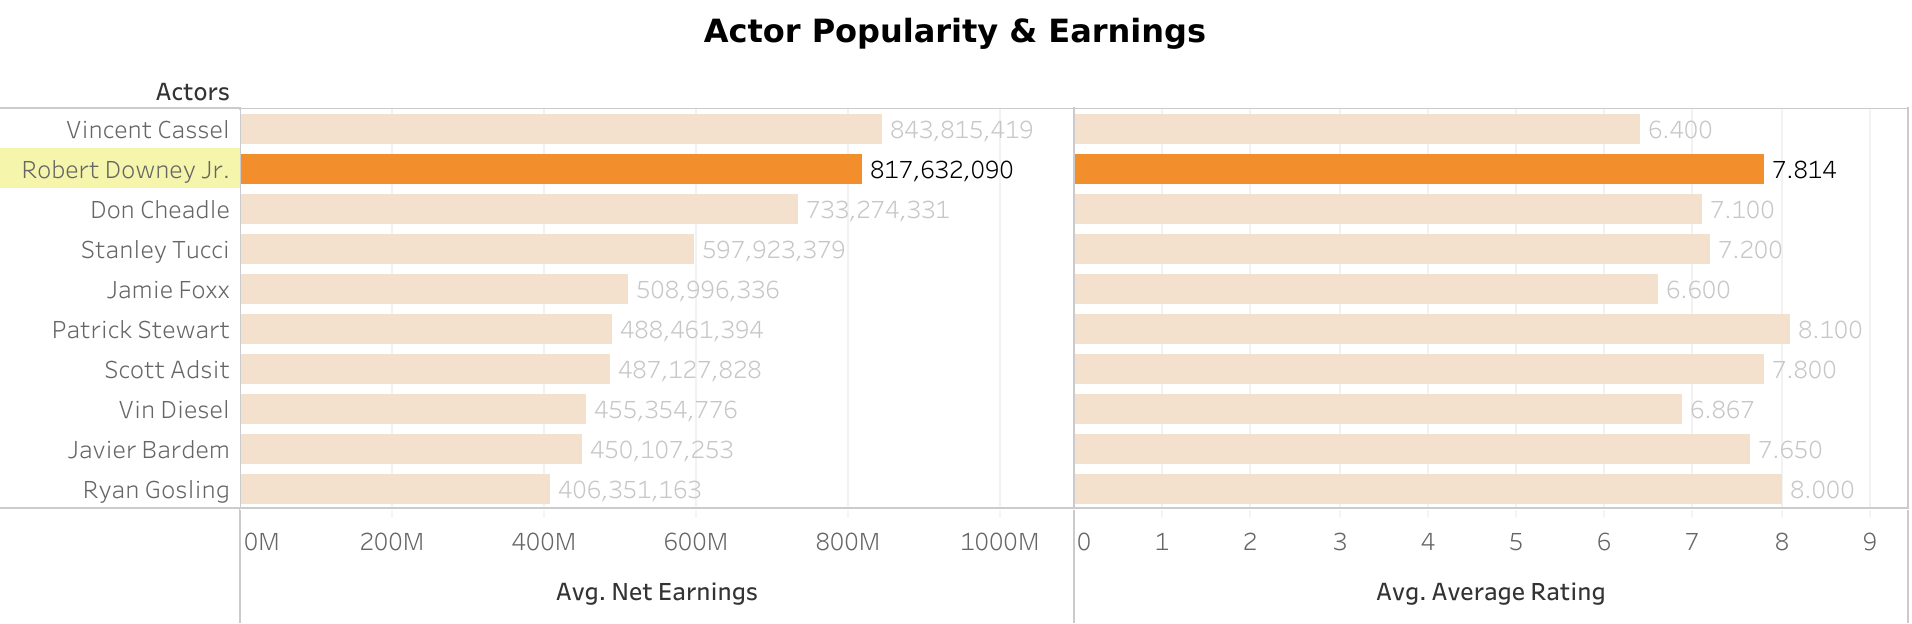

Of course, we can't just throw a gauntlet down and say Robert Downey Jr brings more money to movies he's in, so we performed some testing to ensure that there was a statistical difference between movies containing RDJ and movies without. That being our theory, we must first establish which movies in our data contain RDJ and which do not.

In [68]:
A_List_Actors = Merged_df_1[Merged_df_1['Position'] == 'actor']
A_List_Actors.to_csv('A_List_Actors.csv', index=False)

In [69]:
combo_ONE.head(20)

,Movie ID,Primary Title,Movie Length,Genres,Average Rating,Num of Votes,Primary Name,Position
0,tt8273150,Logistics,51420.0,Documentary,5.0,17,Erika Magnusson,director
1,tt2659636,Modern Times Forever,14400.0,Documentary,6.2,69,Nicolas Gaitan,actor
2,tt2008009,The Clock,1440.0,Drama,8.9,219,Leonardo DiCaprio,archive_footage
3,tt9047474,La flor,808.0,"Drama,Fantasy,Musical",8.5,100,Gabriel Chwojnik,composer
4,tt7528992,Europa: The Last Battle,746.0,Documentary,8.2,162,Winston Churchill,self
5,tt2261469,Double Fine Adventure,724.0,Documentary,8.5,59,Elijah Wood,self
6,tt5374716,Chamisso's Shadow,720.0,Documentary,7.8,19,Bettina Blickwede,editor
7,tt5375100,Paint Drying,607.0,Documentary,9.3,218,Charlie Lyne,self
8,tt3984388,Close Up,500.0,Documentary,6.1,13,Jim Carrey,self
9,tt8296608,Dead Souls,495.0,Documentary,8.3,96,Serge Lalou,producer


In [71]:
df_RBJ = combo_ONE[combo_ONE['Primary Name'] == 'Robert Downey Jr.']

In [72]:
df_RBJ

,Movie ID,Primary Title,Movie Length,Genres,Average Rating,Num of Votes,Primary Name,Position
218,tt4154796,Avengers: Endgame,181.0,"Action,Adventure,Sci-Fi",8.8,441135,Robert Downey Jr.,actor
1444,tt4154756,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926,Robert Downey Jr.,actor
1593,tt3498820,Captain America: Civil War,147.0,"Action,Adventure,Sci-Fi",7.8,583507,Robert Downey Jr.,actor
1988,tt0848228,The Avengers,143.0,"Action,Adventure,Sci-Fi",8.1,1183655,Robert Downey Jr.,actor
2146,tt2395427,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594,Robert Downey Jr.,actor
2162,tt1872194,The Judge,141.0,"Crime,Drama",7.4,162952,Robert Downey Jr.,actor
3418,tt2250912,Spider-Man: Homecoming,133.0,"Action,Adventure,Sci-Fi",7.5,426302,Robert Downey Jr.,actor
26206,tt1231583,Due Date,95.0,"Adventure,Comedy",6.5,303523,Robert Downey Jr.,actor
34230,tt2649194,I Am Steve McQueen,90.0,"Biography,Documentary",7.0,556,Robert Downey Jr.,actor


So, now we have a dataframe containing only the movies (from our data) that RDJ has been in. Now would be a good time to clearly state the hypotheses for our test, and so here they are.

## NULL HYPOTHESIS

RDJ has no effect on a movie's revenue.

## ALTERNATIVE HYPOTHESIS

Movies that RDJ is in make more money.

In [74]:
sample_std = df_RBJ['Average Rating'].std()
sample_mean = df_RBJ['Average Rating'].mean()
population_mean = combo_ONE['Average Rating'].mean()
sample_size = 9

t_score = (sample_mean - population_mean) / (sample_std / sqrt(sample_size))
critical_value_t_score = stats.t.ppf(1 - 0.05, 8)

print ("T-score is:", t_score, "and Critical Value of T-score is:", critical_value_t_score)

T-score is: 5.547811275878463 and Critical Value of T-score is: 1.8595480375228424


In [75]:
Merged_df_1['Net Earnings'] = Merged_df_1['worldwide_gross'] - Merged_df_1['production_budget']

df_RBJ_earings = Merged_df_1[Merged_df_1['Primary Name'] == 'Robert Downey Jr.']
sample_std_1 = df_RBJ_earings['Net Earnings'].std()
sample_mean_1 = df_RBJ_earings['Net Earnings'].mean()
population_mean_1 = Merged_df_1['Net Earnings'].mean()
sample_size_1 = 7

from math import sqrt
from scipy import stats

t_score_1 = (sample_mean_1 - population_mean_1) / (sample_std_1 / sqrt(sample_size_1))
critical_value_t_score_1 = stats.t.ppf(1 - 0.05, 6)

print ("T-score_1 is:", t_score_1, "and Critical Value of T-score_1 is:", critical_value_t_score_1)

T-score_1 is: 2.8612642967130517 and Critical Value of T-score_1 is: 1.9431802803927816


As we can see here, our first step was to establish whether RDJ affected the average ratings of a movie. As you can see, we returned a T-score of 5.547811275878463 and a Critical Value of T-score of 1.8595480375228424. Our next step was to continue the equation by establishing whether those movies made more money. With these calculations, we received a T-score of 2.8612642967130517 and a Critical Value of T-score of 1.9431802803927816.

To interpret these results, we need only remember that our test was done with an alpha of 0.05, and since our T-scores are much higher than our alpha, we can safely reject the null hypothesis and conclude that movies with RDJ in them do make more money.

### Business Recommendation 1

We recommend that should our company branch into movie making, "drama" as a genre is the most highly rated per audience popularity. Meaning, it has the greatest chance of success by genre. The visual to support that information can be seen below.

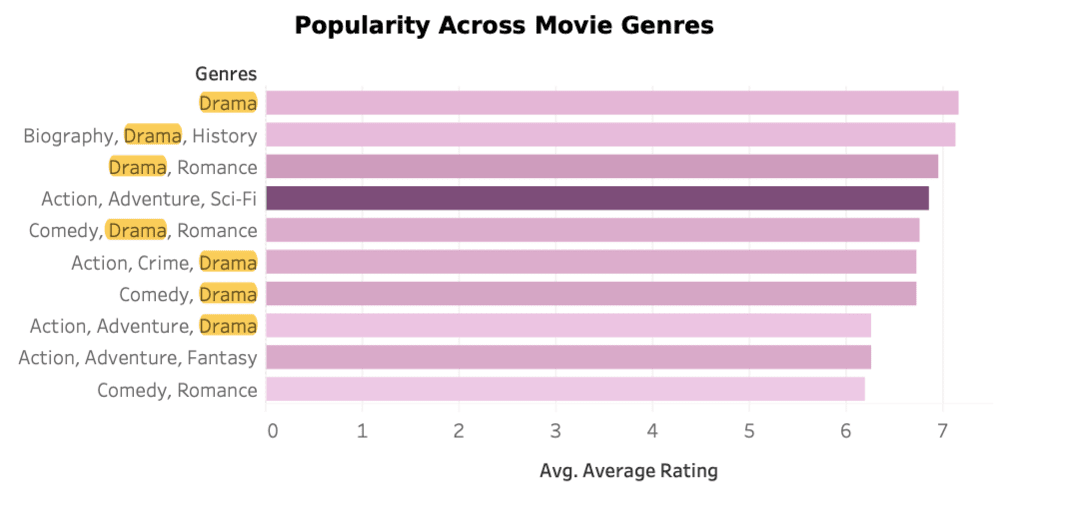

### Business Recommendation 2

By comparing revenue versus expenditure by genre, our team found that while action, adventure & sci-fi (or a combination of those three, like you might find in a Marvel movie) do make the most money and thusly bring in the most revenue, they also cost the most to make. In cross-referencing this with popularity, we have decided to advise that the aforementioned categories might perform better than a drama film if we have the resources available. Animation may also be a worthy option as it allows us to hire larger actors for less money.

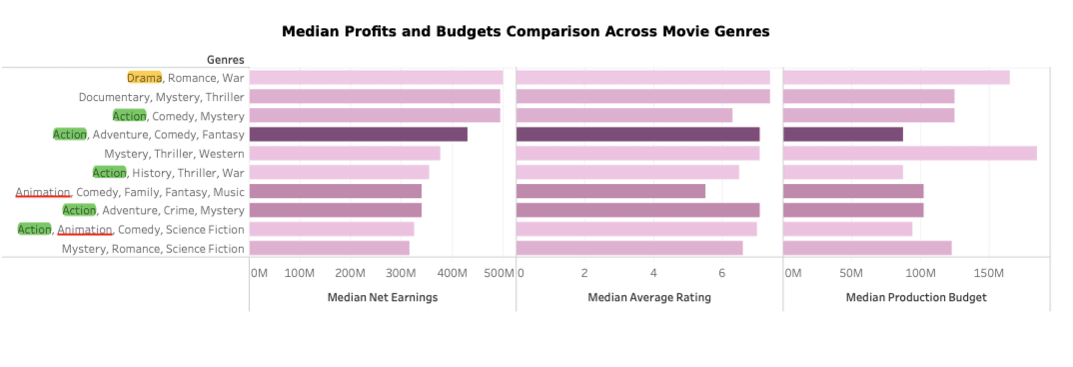

### Business Recommendation 3

Due to the massive hiring cost of Leonardo DiCaprio and the similar popularity rating of Robert Downey Jr, we have advised that it would be somewhat less costly to hire Robert Downey Jr if possible. As a further corollary to the previous point, we may also want to do further research into whether voice acting might be more cost-beneficial than other options.

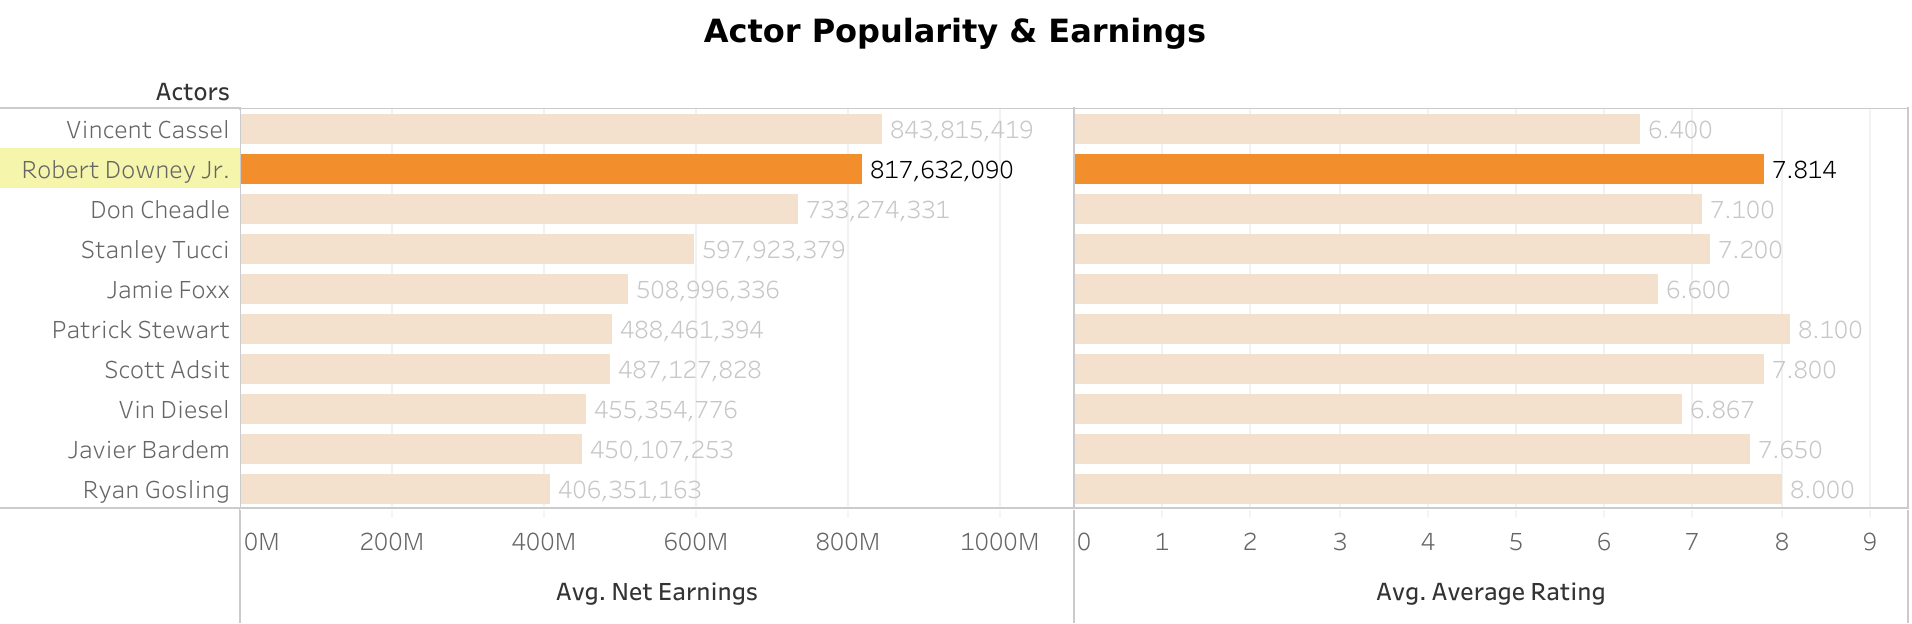

As seen earlier in the notebook, we also ran a T-Test in order to support this hypothesis, and since our T-values were much higher than our alpha of 0.05, we must reject the null hypothesis and conclude that RDJ does affect a movie's earnings.

## Conclusion

In conclusion, we recommend "drama" as a popular movie genre. However, since "drama" as a genre does have somewhat middling revenue returns, we would also recommend "action, adventure & sci-fi" as a viable genre to pursue, provided we have the funds available. "Animation" could also be an option as a genre, because it opens up greater hiring options due to the lessened hiring and other budgetary costs. Finally, we would recommend employing Robert Downey Jr. if the option is available, even if only for voice work.

### Next Steps

Make a movie or don't, Nolan, IDC.